## Задача 8.

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xlrd

import scipy 
from scipy import stats
from scipy.stats import shapiro

import statsmodels as sm
from statsmodels.stats.power import TTestIndPower

In [43]:
df = pd.read_excel('gb_sem_8_hm.xls')
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [44]:
df

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [46]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [47]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [48]:
df.VARIANT_NAME.value_counts()

VARIANT_NAME
variant    5016
control    4984
Name: count, dtype: int64

In [49]:
df.USER_ID.nunique()

6324

In [50]:
df = df.groupby(['USER_ID', 'VARIANT_NAME'], as_index=False).agg({'REVENUE': 'sum'})

In [51]:
df.shape

(7865, 3)

In [52]:
df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': 'count'})['VARIANT_NAME'].value_counts()

VARIANT_NAME
1    4783
2    1541
Name: count, dtype: int64

In [53]:
unique_ids = \
(df
 .groupby('USER_ID', as_index=False)
 .agg({'VARIANT_NAME': 'count'})
 .query('VARIANT_NAME == 1')
 .USER_ID
 .values
 )

In [54]:
df_brief = df[df.USER_ID.isin(unique_ids)].copy(deep=True)

In [55]:
df_brief.shape

(4783, 3)

In [56]:
df_brief.describe

<bound method NDFrame.describe of       USER_ID VARIANT_NAME  REVENUE
0           2      control      0.0
3           4      variant      0.0
4           5      variant      0.0
5           6      variant      0.0
6           9      variant      0.0
...       ...          ...      ...
7856     9990      variant      0.0
7857     9992      control      0.0
7858     9993      control      0.0
7859     9995      variant      0.0
7862     9998      control      0.0

[4783 rows x 3 columns]>

In [ ]:
control = df_brief.query('VARIANT_NAME == "control"')
test = df_brief.query('VARIANT_NAME == "variant"')

Проверим нормальность:

In [59]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Discription is {}normal\n'.format( {True: 'not ',
False: ''}[st[1] < alpha]));

Discription is not normal



График дохода на пользователя по группам:

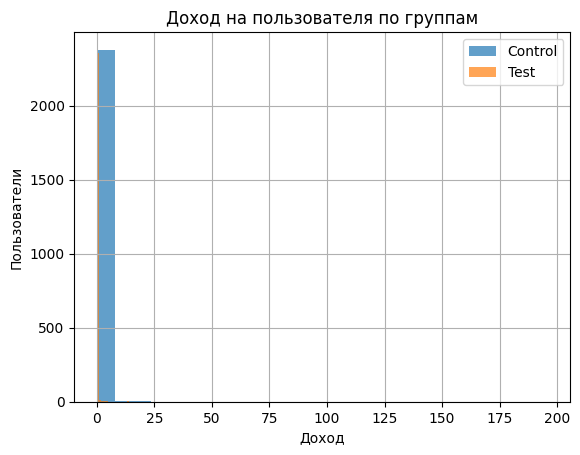

In [61]:
control.REVENUE.hist(bins = 25, alpha = 0.7, label = 'Control')
test.REVENUE.hist(bins = 25, alpha = 0.7, label = 'Test')
plt.title('Доход на пользователя по группам')
plt.xlabel('Доход')
plt.ylabel('Пользователи')
plt.legend();

In [62]:
mw_stats = scipy.stats.mannwhitneyu(x=control.REVENUE.values, y = test.REVENUE.values)

mw_stats

MannwhitneyuResult(statistic=2874161.0, pvalue=0.2104875008271777)

Боксплот:

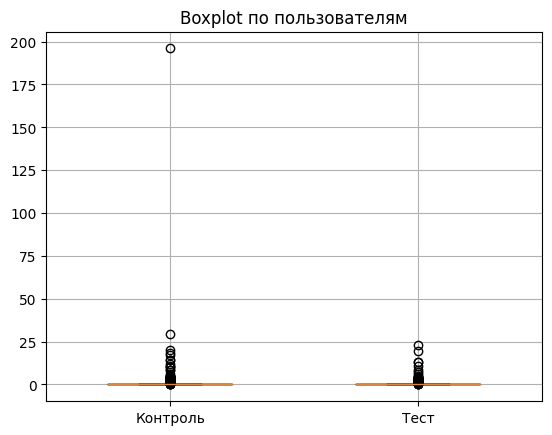

In [63]:
plt.boxplot([control.REVENUE, test.REVENUE],
            labels = ['Контроль', 'Тест'],
            widths = 0.5
            )
plt.title('Boxplot по пользователям', loc='center')
plt.grid(axis='both')

In [70]:
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.3996978409515475, pvalue=0.16172355638776942)

Расчёт мощности:

In [71]:
C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()

C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()

print(len(control.REVENUE.values), len(test.REVENUE.values))

2390 2393


In [74]:
n = len(control.REVENUE.values)
S = np.sqrt((T_std**2 +C_std**2)/2)
ef = float((C_mean-T_mean)/S)

In [75]:
alpha = 0.05
analysis = TTestIndPower()
analysis = sm.stats.power.TTestIndPower()
result = analysis.solve_power(ef, power=None,
                              nobs1=n, ratio=1.0, alpha=alpha)

result

0.28803096229144043

Вывод: статистически значимой разницы между группами нет. По полученным значениям мощности невозможно сделать верное заключение нельзя. Тестируемое изменение применять нецелесообразно. Рекомендую провести тест повторно.